In [1]:
!pip install torchinfo
!nvidia-smi

Thu Jul  4 06:21:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from pytz import timezone

In [9]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
EPOCHS = 30
IMG_SIZE = 224
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5

In [10]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [11]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [12]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [13]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [14]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [15]:
# VGGNet16 모델 정의
class VGGNet16(nn.Module):
    def __init__(self):
        super(VGGNet16, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout = nn.Dropout(DROPOUT)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.fc14 = nn.Linear(512 * 7 * 7, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        x = self.pool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))

        x = self.pool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))

        x = self.pool(x)
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc14(x))
        x = self.dropout(x)
        x = F.relu(self.fc15(x))
        x = self.dropout(x)
        logits = self.fc16(x)

        return logits

torchinfo.summary(
    VGGNet16(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, Conv2d: 1, MaxPool2d: 1, Conv2d: 1, Conv2d: 1, MaxPool2d: 1, Conv2d: 1, Conv2d: 1, Conv2d: 1, MaxPool2d: 1, Conv2d: 1, Conv2d: 1, Conv2d: 1, MaxPool2d: 1, Conv2d: 1, Conv2d: 1, Conv2d: 1, MaxPool2d: 1]

Files already downloaded and verified
Train dataset size: 50000
Validation dataset size: 10000


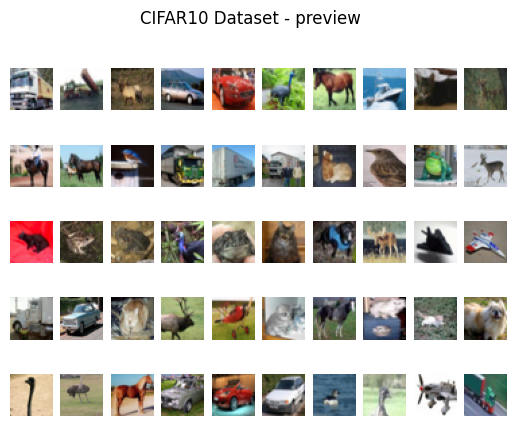

In [19]:
# transforms 정의하기
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
train_dataset = datasets.CIFAR10(
    root="cifar10_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 불러온 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.data[index])

fig.suptitle("CIFAR10 Dataset - preview")

# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

In [20]:
torch.manual_seed(RANDOM_SEED)

model = ModernAlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

15:26:44 ---  Epoch: 0	Train loss: 2.0146	Valid loss: 1.5700	Train accuracy: 44.83	Valid accuracy: 44.15
15:29:45 ---  Epoch: 1	Train loss: 1.5226	Valid loss: 1.3478	Train accuracy: 52.19	Valid accuracy: 51.58
15:32:49 ---  Epoch: 2	Train loss: 1.3406	Valid loss: 1.2771	Train accuracy: 57.02	Valid accuracy: 55.68
15:36:00 ---  Epoch: 3	Train loss: 1.2130	Valid loss: 1.0699	Train accuracy: 64.60	Valid accuracy: 63.22
15:39:03 ---  Epoch: 4	Train loss: 1.0728	Valid loss: 1.0691	Train accuracy: 66.44	Valid accuracy: 64.07
15:42:03 ---  Epoch: 5	Train loss: 0.9717	Valid loss: 0.9732	Train accuracy: 70.01	Valid accuracy: 67.57
15:45:04 ---  Epoch: 6	Train loss: 0.8791	Valid loss: 1.1355	Train accuracy: 64.83	Valid accuracy: 61.54
15:48:06 ---  Epoch: 7	Train loss: 0.7791	Valid loss: 0.7733	Train accuracy: 78.20	Valid accuracy: 73.80
15:51:07 ---  Epoch: 8	Train loss: 0.7064	Valid loss: 0.7270	Train accuracy: 81.47	Valid accuracy: 76.36
15:54:08 ---  Epoch: 9	Train loss: 0.6192	Valid loss: 0